## Project

Jin Kyoung Lee\
PHYS 427 A

### 1. Introduction

* Analyzation and optimization of 13 TeV data to predict amount of data needed to get higher statistical significance of detecting Higgs.
* Statistical significance $(\sigma) = \frac{number of signal events}{\sqrt{number of background events}}$
* By observing the histogram, criteria for making cuts for higgs detection will be set up.
* In this project, the signal that will be analyzed is Higgs boson. (Higgs boson decays into 2 W bosons, W and W$*$, and each boson decays into leptons (electron or muon) and neutrinos. H → WW$*$ → evµv);
* and, the background will be WW, top quark pairs, and top single quark.

### 2. Data analysis

#### A. Importing data
* Data used: ATLAS 13 TeV samples collection with at least two leptons (electron or muon), for 2020 Open data released (http://opendata.cern.ch/record/15003)
* Signal: Higgs boson, SM H → WW*
* Background: non-resonant WW, ttbar, and single top quark

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import uproot
import seaborn as sns
import pandas as pd
import awkward

In [2]:
# importing root files
signal = uproot.open("project/data/2lep/MC/mc_345324.ggH125_WW2lep.2lep.root") # signal SM H -> WW*
bgWW = uproot.open("project/data/2lep/MC/mc_363492.llvv.2lep.root") # Background non-resonant WW
bgTTbar = uproot.open("project/data/2lep/MC/mc_410000.ttbar_lep.2lep.root") # Background top quark pair
bgT = uproot.open("project/data/2lep/MC/mc_410013.single_top_wtchan.2lep.root") # Background single top quark

In [3]:
signaltree = signal["mini"].lazyarrays(persistvirtual = True, basketcache = uproot.cache.ThreadSafeArrayCache(1024**10))
bgWWtree = bgWW["mini"].lazyarrays(persistvirtual = True, basketcache = uproot.cache.ThreadSafeArrayCache(1024**10))
bgTTbartree = bgTTbar["mini"].lazyarrays(persistvirtual = True, basketcache = uproot.cache.ThreadSafeArrayCache(1024**10))
bgTtree = bgT["mini"].lazyarrays(persistvirtual = True, basketcache = uproot.cache.ThreadSafeArrayCache(1024**10))

#### B. Expected number of events

In [4]:
numEventbgWW = len(bgWWtree["eventNumber"])
numEventbgTTbar = len(bgTTbartree["eventNumber"])
numEventbgT = len(bgTtree["eventNumber"])
numEventSignal = len(signaltree["eventNumber"])

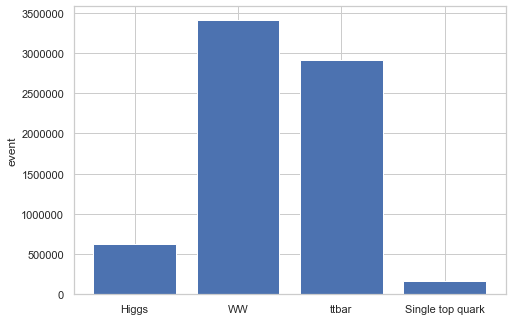

Number of events: 
* Higgs:  628685 
* WW:  3409043 
* ttbar:  2910539 
* Single top quark:  165554

Total signal of 628685 events, and total background of 6485136 events


In [46]:
# Plotting bar plot to see number of events for each process
numEventfig = plt.figure()
ax = numEventfig.add_axes([0,0,1,1])
process = ['Higgs', 'WW', 'ttbar', 'Single top quark']
numEvents = [numEventSignal, numEventbgWW, numEventbgTTbar, numEventbgT]
ax.bar(process, numEvents)
plt.ylabel("event")
plt.show()

print("Number of events:",
      "\n* Higgs: ", numEventSignal,
      "\n* WW: ", numEventbgWW,
      "\n* ttbar: ", numEventbgTTbar,
      "\n* Single top quark: ", numEventbgT)
print("\nTotal signal of", numEventSignal, "events, and",
      "total background of", numEventbgWW + numEventbgTTbar + numEventbgT, "events")

Without making any cuts, there are 628685 signal events and 6485136 background events.

#### C. Reconstructed Dilepton Mass

For reconstructed dilepton mass, the invariant mass of two leptons is calculated.

In [6]:
# Defining function for invariant dileptop mass
def invDilepM(tree, binNum, xlabel, xlim, clr):
    
    # px = pt*cos(phi)
    px1 = (tree["lep_pt"][:,0]/1000) * np.cos(tree["lep_phi"][:,0])
    px2 = (tree["lep_pt"][:,1]/1000) * np.cos(tree["lep_phi"][:,1])

    # py = pt*sin(phi)
    py1 = (tree["lep_pt"][:,0]/1000) * np.sin(tree["lep_phi"][:,0])
    py2 = (tree["lep_pt"][:,1]/1000) * np.sin(tree["lep_phi"][:,1])

    # pz = pt * sinh(eta)
    pz1 = (tree["lep_pt"][:,0]/1000) * np.sinh(tree["lep_eta"][:,0])
    pz2 = (tree["lep_pt"][:,1]/1000) * np.sinh(tree["lep_eta"][:,1])

    # E
    E1 = tree["lep_E"][:,0]/1000
    E2 = tree["lep_E"][:,1]/1000
    
    # Sum of leading and trail leptons
    px = px1 + px2
    py = py1 + py2
    pz = pz1 + pz2
    E = E1 + E2
    
    # Invariant mass
    invM = np.sqrt(np.square(E) - np.square(px) - np.square(py) - np.square(pz))
    
    # Histogram of reconstructed dilepton mass
    plt.figure(figsize = (7,5))
    sns.distplot(invM, kde = False, bins = binNum, color = clr)
    sns.set(style = "whitegrid")
    plt.xlabel(xlabel)
    plt.ylabel("Events")
    plt.xlim(xlim)
    
    return invM

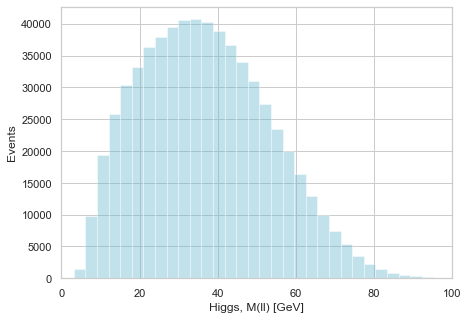

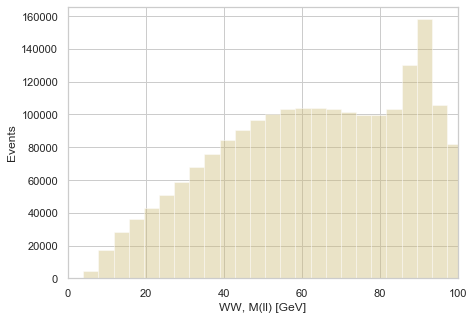

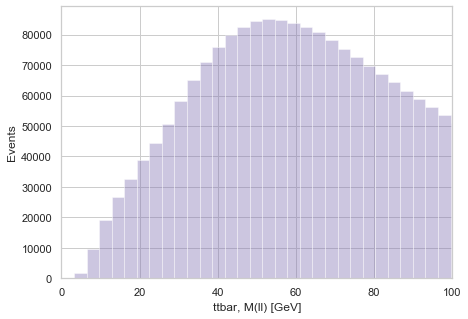

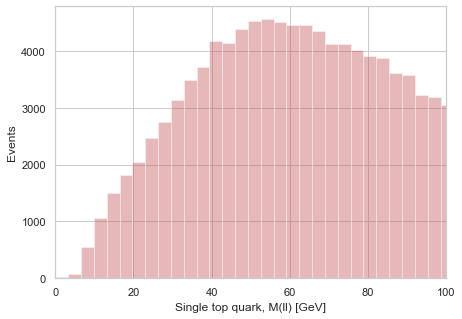

In [60]:
# Plotting histrogam for reconstructed mass
reconMsignal = invDilepM(signaltree, 500, "Higgs, M(ll) [GeV]", [0,100], 'c')
reconMWW = invDilepM(bgWWtree, 1500, "WW, M(ll) [GeV]", [0,100], 'y')
reconMTTbar = invDilepM(bgTTbartree, 1000, "ttbar, M(ll) [GeV]", [0,100], 'm')
reconMT = invDilepM(bgTtree, 500, "Single top quark, M(ll) [GeV]", [0,100], 'r')

##### By seeing the histogram, the reconstructed dilepton mass:
* for Higgs peaks at 30 - 40 GeV.
* for WW peaks at 85 - 90 GeV.
* for top quark pair peaks at around 50 - 60 GeV.
* for single top quark peaks at 50 - 70 GeV.

#### D. Number of Jets

In [8]:
def hist(tree, var, div, binNum, xlabel, xlim, clr):
    plt.figure(figsize = (7, 5))
    sns.distplot(tree[var]/div, kde = False, bins = binNum, color = clr)
    sns.set(style = "whitegrid")
    plt.xlabel(xlabel)
    plt.ylabel("Events")
    plt.xlim(xlim)

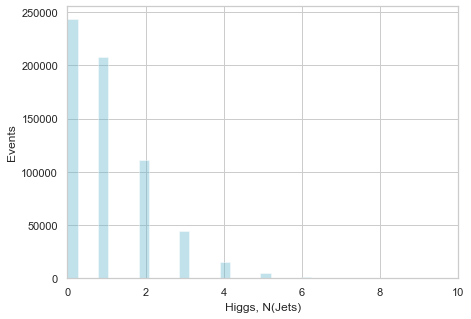

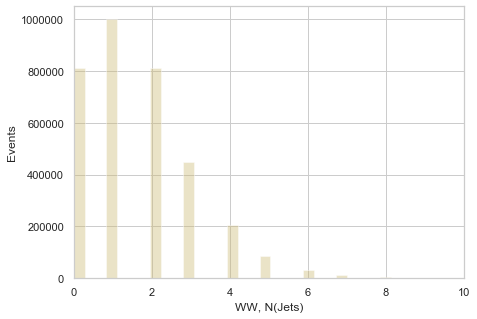

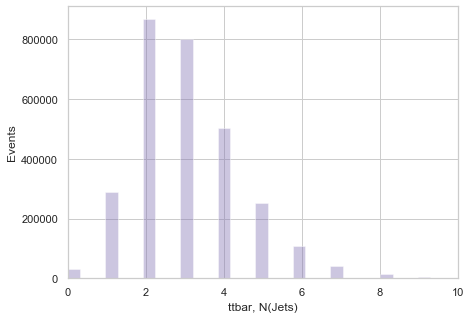

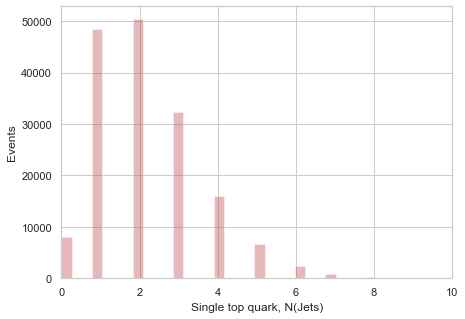

In [9]:
hist(signaltree, "jet_n", 1, 50, "Higgs, N(Jets)", [0,10], 'c')
hist(bgWWtree, "jet_n", 1, 50, "WW, N(Jets)", [0,10], 'y')
hist(bgTTbartree, "jet_n", 1, 50, "ttbar, N(Jets)", [0,10], 'm')
hist(bgTtree, "jet_n", 1, 50, "Single top quark, N(Jets)", [0,10], 'r')

##### The number of jets:
* for Higgs are mostly 0 or 1.
* for WW are mostly 0, 1, or 2.
* for top quark pair are mostly 2 or 3.
* for single top quark are mostly 1 or 2.

#### E. B-Tagging

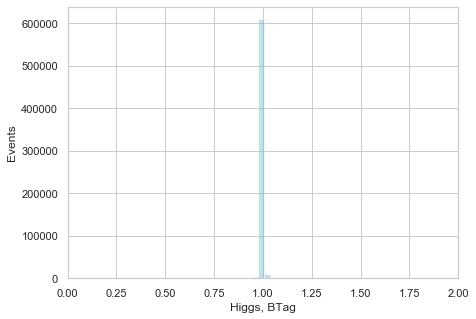

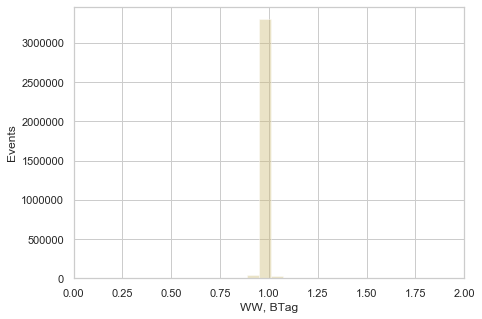

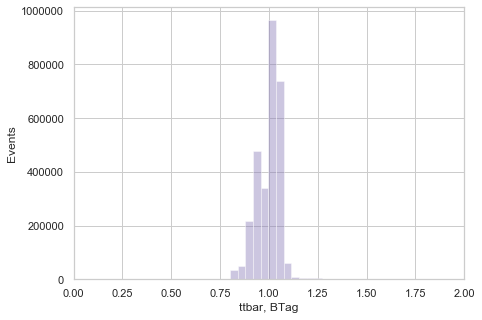

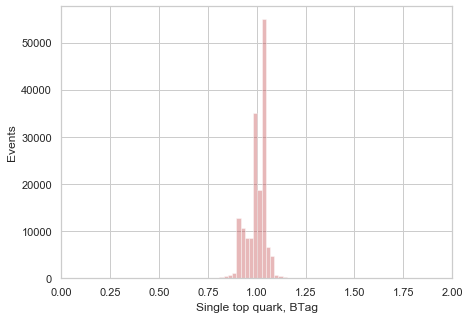

In [10]:
hist(signaltree, "scaleFactor_BTAG", 1, 50, "Higgs, BTag", [0,2], 'c')
hist(bgWWtree, "scaleFactor_BTAG", 1, 50, "WW, BTag", [0,2], 'y')
hist(bgTTbartree, "scaleFactor_BTAG", 1, 50, "ttbar, BTag", [0,2], 'm')
hist(bgTtree, "scaleFactor_BTAG", 1, 50, "Single top quark, BTag", [0,2], 'r')

##### Here, is it analyzed whether jets are b-tagged.

* Higgs: no b-tagged jets.
* WW: no b-tagged jets.
* Top quark pair: b-tagged jets.
* Single top quark: b-tagged jets.

#### F. Missing Transverse Momentum

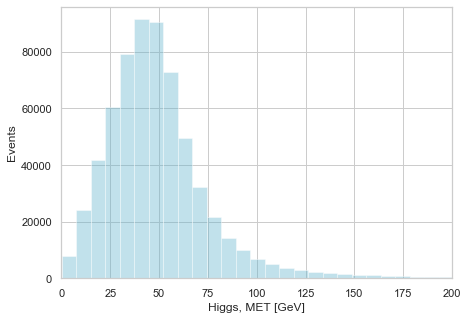

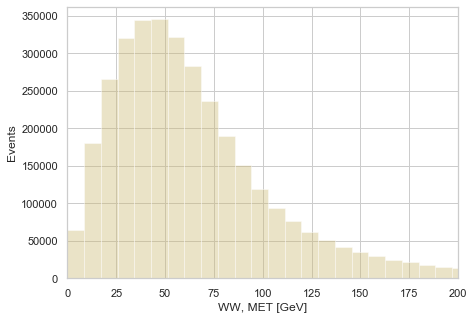

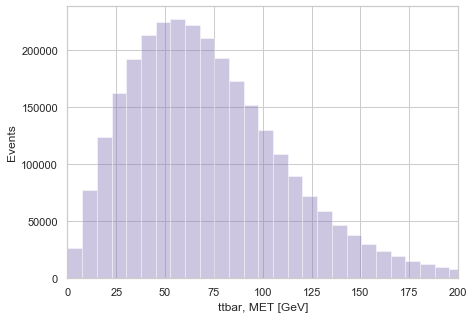

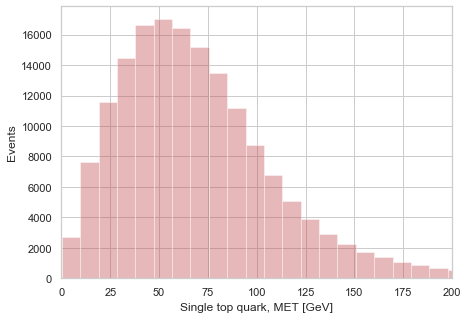

In [11]:
hist(signaltree, "met_et", 1000, 1000, "Higgs, MET [GeV]", [0,200], 'c')
hist(bgWWtree, "met_et", 1000, 3000, "WW, MET [GeV]", [0,200], 'y')
hist(bgTTbartree, "met_et", 1000, 3000, "ttbar, MET [GeV]", [0,200], 'm')
hist(bgTtree, "met_et", 1000, 1000, "Single top quark, MET [GeV]", [0,200], 'r')

##### The peak missing transverse momentum:
* for Higgs, occurs at 35 - 50 GeV.
* for WW, occurs at 30 - 50 GeV.
* for top quark pair, occurs at 40 - 70 GeV.
* for single top quark, occurs at 30 - 60 GeV.

#### G. Total Lepton Transverse Momentum

In [12]:
def histLepPt(tree, binNum, xlabel, xlim, clr):
    totalLepPt = tree["lep_pt"][:,0] + tree["lep_pt"][:,1]
    plt.figure(figsize = (7, 5))
    sns.distplot(totalLepPt/1000, kde = False, bins = binNum, color = clr)
    sns.set(style = "whitegrid")
    plt.xlabel(xlabel)
    plt.ylabel("Events")
    plt.xlim(xlim)

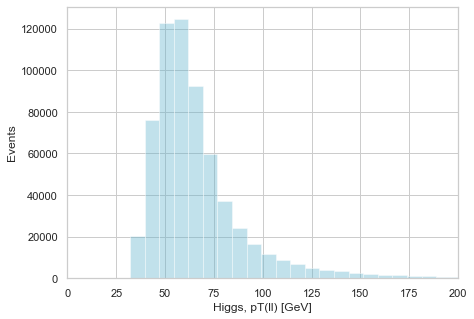

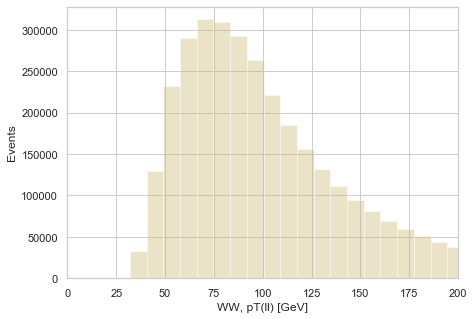

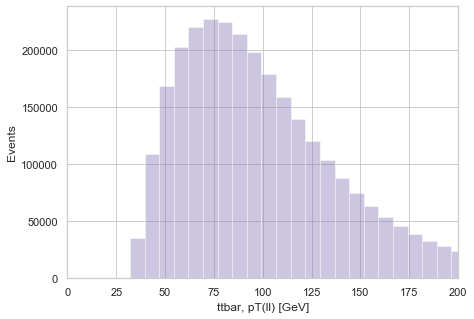

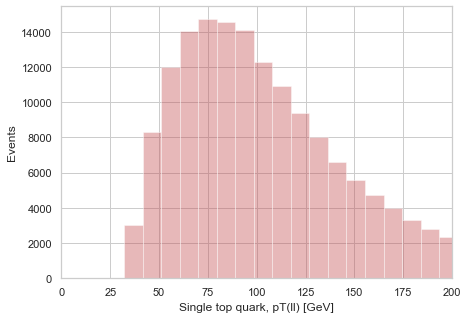

In [13]:
histLepPt(signaltree, 1000, "Higgs, pT(ll) [GeV]", [0,200], 'c')
histLepPt(bgWWtree, 3000, "WW, pT(ll) [GeV]", [0,200], 'y')
histLepPt(bgTTbartree, 3000, "ttbar, pT(ll) [GeV]", [0,200], 'm')
histLepPt(bgTtree, 1000, "Single top quark, pT(ll) [GeV]", [0,200], 'r')

##### The total lepton transverse momentum:
* for Higgs, peaks at 50 - 60 GeV.
* for WW, peaks at 60 - 80 GeV.
* for top quark pair, peaks at 60 - 80 GeV.
* for single top quark, peaks at 60 - 80 GeV.

### 3. Analysis summary

* The reconstructed mass for Higgs peaks at 30 - 40 GeV, while other events peak around the value greater than 50 GeV. Hence, if we set the reconstructed mass restricted less than 50 GeV, then we can remove majority portion of background events.
* It is shown that Higgs events have mostly zero or 1 Jets, while other events also have 2 or 3 jets in the events. Therefore, restricting the number of jets less than 2, we can make another cuts to the background events.
* B-Tagging: there is no b-tagged jets in Higgs events, so we can remove some of the portion of top quark pair and single top quark.
* The missing transverse momentum: Since the range of the peak missing transverse momentum of each event is similar to one another, so it did not contribute to the cuts. greater than 30 GeV
* It is shown that all of the background events have peak value greater than 60 GeV, while Higgs event has its peak transverse momentum less than 60 GeV, so set the restriction less than 60 GeV, it is possible to remove the background events.

In [23]:
# Total transverse momentum of dilepton
def totPt(tree, fileName):
    totPt = tree[tree["lep_pt"][:,0]/1000 + tree["lep_pt"][:,1]/1000 < 60]
    awkward.save(fileName, totPt, mode = "w")
    totPtCut = awkward.load(fileName)
    
    return totPtCut

In [24]:
totPtSig = totPt(signaltree, "totPt_sig.awkd")
totPtWW = totPt(bgWWtree, "totPt_WW.awkd")
totPtTTbar = totPt(bgTTbartree, "totPt_ttbar.awkd")
totPtT = totPt(bgTtree, "totPt_singletop.awkd")

In [25]:
# Number of jets cut
def numJets(totPt, fileName):
    numJets = totPt[totPt["jet_n"] < 2]
    awkward.save(fileName, numJets, mode = "w")
    numJetsCut = awkward.load(fileName)
    
    return numJetsCut

In [26]:
numJetsSig = numJets(totPtSig, "numJets_sig.awkd")
numJetsWW = numJets(totPtWW, "numJets_WW.awkd")
numJetsTTbar = numJets(totPtTTbar, "numJets_ttbar.awkd")
numJetsT = numJets(totPtT, "numJets_singletop.awkd")

In [53]:
# Missing transverse momentum cut
def met(numJets, fileName):
    met = numJets[numJets["met_et"]/1000 > 30]
    awkward.save(fileName, met, mode = "w")
    metCut = awkward.load(fileName)
    
    return metCut

In [54]:
metSig = met(numJetsSig, "met_sig.awkd")
metWW = met(numJetsWW, "met_WW.awkd")
metTTbar = met(numJetsTTbar, "met_ttbar.awkd")
metT = met(numJetsT, "met_singletop.awkd")

In [55]:
# B-Tagging
def btag(metCut, fileName):
    btag = metCut[metCut["scaleFactor_BTAG"] < 1]
    awkward.save(fileName, btag, mode = "w")
    btagCut = awkward.load(fileName)
    
    return btagCut

In [56]:
cutsSig = btag(metSig, "btag_sig.awkd")
cutsWW = btag(metWW, "btag_WW.awkd")
cutsTTbar = btag(metTTbar, "btag_ttbar.awkd")
cutsT = btag(metT, "btag_singletop.awkd")

In [57]:
numSigCut = len(cutsSig)
numWWCut = len(cutsWW)
numTTbarCut = len(cutsTTbar)
numTCut = len(cutsT)

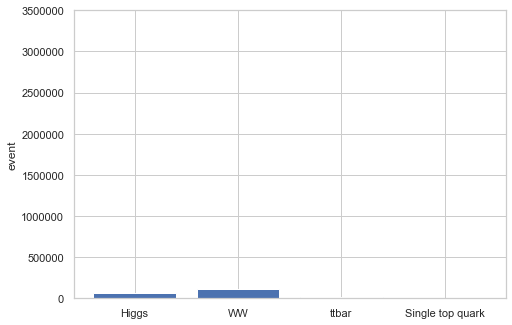

Number of events: 
* Higgs:  68649 
* WW:  110055 
* ttbar:  14098 
* Single top quark:  2158

Total signal of 68649 events, and total background of 126311 events


In [58]:
# Plotting bar plot to see number of events after making cuts
numEventCutfig = plt.figure()
axCut = numEventCutfig.add_axes([0,0,1,1])
process = ['Higgs', 'WW', 'ttbar', 'Single top quark']
numEventsCut = [numSigCut, numWWCut, numTTbarCut, numTCut]
axCut.bar(process, numEventsCut)
plt.ylabel("event")
plt.ylim([0,3500000])
plt.show()

print("Number of events:",
      "\n* Higgs: ", numSigCut,
      "\n* WW: ", numWWCut,
      "\n* ttbar: ", numTTbarCut,
      "\n* Single top quark: ", numTCut)
print("\nTotal signal of", numSigCut, "events, and",
      "total background of", numWWCut + numTTbarCut + numTCut, "events")

The statistical significance is number of signal events over the square-root of number of background events, using the results above, the significance is:

In [62]:
significance = len(cutsSig) / np.sqrt(len(cutsWW)+len(btagTTbar)+len(btagT))
significance

198.91660657312374

However, this number is wrong, since statistical significance cannot be exeed 6. Hence, I've looked again from the top of this notebook, and I've realized that I did not do the event selection before making any cuts, and it ruined the analyzation.
However, I will explain what I would do, if I got the correct value for significance.

If the data has been analyzed and optimized correctly, the statistical significance probably be less than 1 sigma referring to the 8 TeV data, and it is required 5 sigma significance to claim a detection. Therefore, we can set the significance equation greater than 3 to find the constant that can be used to calculate the number of data giving better significance.

It is supposed that the signal events and the background events after making cuts are proportional to each other, so we can multiply constant $n$ to both events and can set up the equation as follow:

$\frac{numSigEvent*n}{\sqrt{numBgEvent*n}} > 3$, (where, numSigEvent = number of signal event, and numBgEvent = number of background events)

and, solving it for constant $n$,

$numSigEvent^2*n^2 - 3*numBgEvent*n > 0$

$n*(numSigEvent^2*n - 3*numBgEvent) > 0$

$n> \frac{3*numBgEvent}{numSigEvent^2}$

Find the constant $n$, and multiplying $n$ to the luminosity for our data, which is 10/fb, the data needed to get better statistical significance can be found.